### Neural Network Classification Problem

### 1. Make classification data and get it ready

In [78]:
from sklearn.datasets import make_circles

In [79]:
# Make 1000 Samples
n_samples = 1000

# Create circles
X, y = make_circles(n_samples, noise=0.03, random_state=42)

In [80]:
len(X), len(y)

(1000, 1000)

In [81]:
print(f"First 10 samples: {X[:10]}")
print(f"First 10 labels: {y[:10]}")

First 10 samples: [[ 0.75424625  0.23148074]
 [-0.75615888  0.15325888]
 [-0.81539193  0.17328203]
 [-0.39373073  0.69288277]
 [ 0.44220765 -0.89672343]
 [-0.47964637  0.67643477]
 [-0.01364836  0.80334872]
 [ 0.77151327  0.14775959]
 [-0.16932234 -0.79345575]
 [-0.1214858   1.02150905]]
First 10 labels: [1 1 1 1 0 1 1 1 1 0]


In [82]:
import pandas as pd
circles = pd.DataFrame({"x1" : X[:, 0], "x2" : X[:, 1], "label" : y})
circles.head(10)

,x1,x2,label
0,0.754246,0.231481,1
1,-0.756159,0.153259,1
2,-0.815392,0.173282,1
3,-0.393731,0.692883,1
4,0.442208,-0.896723,0
5,-0.479646,0.676435,1
6,-0.013648,0.803349,1
7,0.771513,0.147760,1
8,-0.169322,-0.793456,1
9,-0.121486,1.021509,0


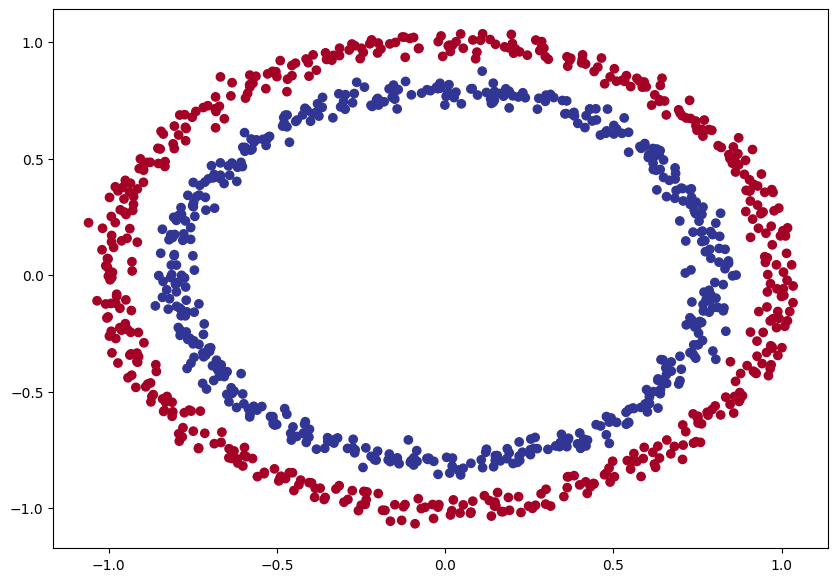

In [83]:
# Visualize the data
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 7))
plt.scatter(x=X[:, 0], y=X[:,1], c=y, cmap=plt.cm.RdYlBu)
plt.show()

#### 1.1 Check input and output shaped

In [84]:
X.shape, y.shape

((1000, 2), (1000,))

In [85]:
# View the first example of features and labels
X[0], y[0]

(array([0.75424625, 0.23148074]), 1)

##### 1.2 Turn data into tensors and create train and and test splits

In [86]:
import torch

In [87]:
# Turn data into tensors
X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)

X[:10], y[:10]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967],
         [-0.4796,  0.6764],
         [-0.0136,  0.8033],
         [ 0.7715,  0.1478],
         [-0.1693, -0.7935],
         [-0.1215,  1.0215]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [88]:
X.dtype, y.dtype, type(X), type(y)

(torch.float32, torch.float32, torch.Tensor, torch.Tensor)

In [89]:
# Split data into train and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [90]:
len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [91]:
n_samples

1000

##### 2. Building a model

Let's build a model to classify our blue and red dots.

To do so, we want to:
1. setup deevice agnostic function so our code run via GPU if available
2. Construct a model (by subclassing the nn.Module class from PyTorch)
3. Define a loss function and optimizer
4. Create a training and test loop

In [92]:
import torch
from torch import nn

# Make device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now we've setup device agnostic code, let's create a model that:

1. Subclasses `nn.Module` (almost all PyTorch models start this way).
2. Createe 2 `nn.Linear()` layers that are capablee of handling the shapes of our data.
3. Deefines the forward method, which specifies how the model should operate on the input to make predictions.
4. Instantiates the model and send it to the device.

In [93]:
# 1. Construct a modeel that Subclasses the nn.Module
class CircleModelV0(nn.Module):
    def __init__(self):
        super().__init__()
        # 2. Create 2 nn.Linear layers capable of handling the shapes of our data
        self.fc1 = nn.Linear(2, 5) # takes in 2 features and upscales to 5 features
        self.fc2 = nn.Linear(5, 1) # takes in 5 features and downscales to 1 feature
        
        self.two_linear_layers = nn.Sequential(
            nn.Linear(2, 5),
            nn.Linear(5, 1)
        )

    # 3. Define the forward method that oulines the forward pass
    def forward(self, x):
        return self.two_linear_layers(x)
    

# 4. Instantiate the model and send it to the device
model_0 = CircleModelV0().to(device)
model_0 , device

(CircleModelV0(
   (fc1): Linear(in_features=2, out_features=5, bias=True)
   (fc2): Linear(in_features=5, out_features=1, bias=True)
   (two_linear_layers): Sequential(
     (0): Linear(in_features=2, out_features=5, bias=True)
     (1): Linear(in_features=5, out_features=1, bias=True)
   )
 ),
 'cpu')

##### Let's replicate the model's architecture using PyTorch Sequential API
model_0 = nn.Sequential(
    nn.Linear(2, 5),
    nn.Linear(5, 1)
).to(device)

model_0

In [94]:
model_0.state_dict()

OrderedDict([('fc1.weight',
              tensor([[ 0.5406,  0.5869],
                      [-0.1657,  0.6496],
                      [-0.1549,  0.1427],
                      [-0.3443,  0.4153],
                      [ 0.6233, -0.5188]])),
             ('fc1.bias', tensor([0.6146, 0.1323, 0.5224, 0.0958, 0.3410])),
             ('fc2.weight',
              tensor([[-0.0631,  0.3448,  0.0661, -0.2088,  0.1140]])),
             ('fc2.bias', tensor([-0.2060])),
             ('two_linear_layers.0.weight',
              tensor([[-0.0829, -0.2872],
                      [ 0.4691, -0.5582],
                      [-0.3260, -0.1997],
                      [-0.4252,  0.0667],
                      [-0.6984,  0.6386]])),
             ('two_linear_layers.0.bias',
              tensor([-0.6007,  0.5459,  0.1177, -0.2296,  0.4370])),
             ('two_linear_layers.1.weight',
              tensor([[ 0.0697,  0.3613,  0.0489, -0.1410,  0.1202]])),
             ('two_linear_layers.1.bias', tensor([-

In [95]:
# Make predictions
with torch.inference_mode():
    untrained_preds = model_0(X_test.to(device))
print(f"Lenght of untrained_preds: {len(untrained_preds)}, shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(X_test)}, shape: {X_test.shape}")
print(f"\nFirst 10 predictions: {untrained_preds[:10]}")
print(f"\nFirst 10 labels: {y_test[:10]}")

Lenght of untrained_preds: 200, shape: torch.Size([200, 1])
Length of test samples: 200, shape: torch.Size([200, 2])

First 10 predictions: tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967],
        [ 0.2968],
        [ 0.1405],
        [ 0.2178],
        [ 0.0805],
        [-0.0284]])

First 10 labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


In [96]:
X_test[:10], y_test[:10]

(tensor([[-0.3752,  0.6827],
         [ 0.0154,  0.9600],
         [-0.7028, -0.3147],
         [-0.2853,  0.9664],
         [ 0.4024, -0.7438],
         [ 0.6323, -0.5711],
         [ 0.8561,  0.5499],
         [ 1.0034,  0.1903],
         [-0.7489, -0.2951],
         [ 0.0538,  0.9739]]),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.]))

#### 2.1 seetup loss function and optimizer

which loss function or optimizer should you use?

Again... this is problem specific.

For example for regression problems you might use: Mean Squared Error (MSE) loss and Adam optimizer.

For binary classification problems you might use: Binary Crossentropy loss and Adam optimizer.



In [97]:
# Setup the loss function
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy with Logits Loss With sigmoid function

optimizer = torch.optim.SGD(model_0.parameters(), lr=0.01)

In [98]:
# Calculate accuracy - out of 100 exampls, what percentage does our model get right?
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_true)) * 100
    return acc

### Training Model

To train the model we are going to build a training loop:

1. Forward pass
2. calculate loss
3. optimer zero grad
4. backward pass
5. optimizer step


#### 3.1 Going from raw logits -> prediction probabilities -> prediction labels

In [99]:
model_0

CircleModelV0(
  (fc1): Linear(in_features=2, out_features=5, bias=True)
  (fc2): Linear(in_features=5, out_features=1, bias=True)
  (two_linear_layers): Sequential(
    (0): Linear(in_features=2, out_features=5, bias=True)
    (1): Linear(in_features=5, out_features=1, bias=True)
  )
)

In [100]:
# View the first 5 outputs of thee forward pass on the test set
with torch.inference_mode():
    model_0_preds = model_0(X_test.to(device))[:5]
model_0_preds

tensor([[-0.0338],
        [-0.0309],
        [ 0.0894],
        [-0.0692],
        [ 0.2967]])

In [101]:
y_test[:5]

tensor([1., 0., 1., 0., 1.])

In [102]:
# Use the sigmoid activation function on our model logits to turn them into prediction probabilites
y_pred = torch.sigmoid(model_0_preds)
y_pred

tensor([[0.4916],
        [0.4923],
        [0.5223],
        [0.4827],
        [0.5736]])

In [103]:
y_pred = torch.round(y_pred)
print(torch.eq(y_pred.squeeze(), model_0_preds.squeeze()))

y_pred.squeeze()

tensor([False, False, False, False, False])


tensor([0., 0., 1., 0., 1.])

In [104]:
torch.random.manual_seed(42)
torch.cuda.manual_seed(42)

Epochs = 2000

# Put the data on the GPU
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Training loop
for epoch in range(Epochs):
    model_0.train()

    # Forward pass
    y_logits = model_0(X_train.to(device)).squeeze()
    y_labels = torch.round(torch.sigmoid(y_logits)) # Turn logits -> pred probs -> binary labels

    # Calculate loss/accuracy
    loss = loss_fn(y_logits, y_train)

    acc = accuracy_fn(y_train, y_labels)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the model
    optimizer.step()

    # Test the model
    model_0.eval()
    with torch.inference_mode():
        test_logits = model_0(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)



    # Print some metrics
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.70 | Accuracy: 51.88 | Test Loss: 0.69 | Test Accuracy: 57.50
Epoch: 10 | Loss: 0.70 | Accuracy: 52.00 | Test Loss: 0.69 | Test Accuracy: 58.00
Epoch: 20 | Loss: 0.70 | Accuracy: 52.00 | Test Loss: 0.69 | Test Accuracy: 57.50
Epoch: 30 | Loss: 0.70 | Accuracy: 52.00 | Test Loss: 0.69 | Test Accuracy: 56.50
Epoch: 40 | Loss: 0.70 | Accuracy: 51.62 | Test Loss: 0.69 | Test Accuracy: 56.50
Epoch: 50 | Loss: 0.70 | Accuracy: 51.38 | Test Loss: 0.69 | Test Accuracy: 56.00
Epoch: 60 | Loss: 0.70 | Accuracy: 51.38 | Test Loss: 0.69 | Test Accuracy: 56.00
Epoch: 70 | Loss: 0.70 | Accuracy: 51.38 | Test Loss: 0.69 | Test Accuracy: 56.50
Epoch: 80 | Loss: 0.70 | Accuracy: 51.25 | Test Loss: 0.69 | Test Accuracy: 56.50
Epoch: 90 | Loss: 0.70 | Accuracy: 51.38 | Test Loss: 0.69 | Test Accuracy: 55.00
Epoch: 100 | Loss: 0.70 | Accuracy: 51.12 | Test Loss: 0.69 | Test Accuracy: 54.00
Epoch: 110 | Loss: 0.70 | Accuracy: 51.00 | Test Loss: 0.69 | Test Accuracy: 53.00
Epoch: 120 | Lo

### 4. Make predictions and evaluate the model

From the metrics it looks like out model isn't learning anything

In [29]:
import requests

# Download the helper functions
url = r"https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/refs/heads/main/helper_functions.py"
response = requests.get(url)

with open("utils.py", "w") as f:
    f.write(response.text)

from utils import plot_decision_boundary

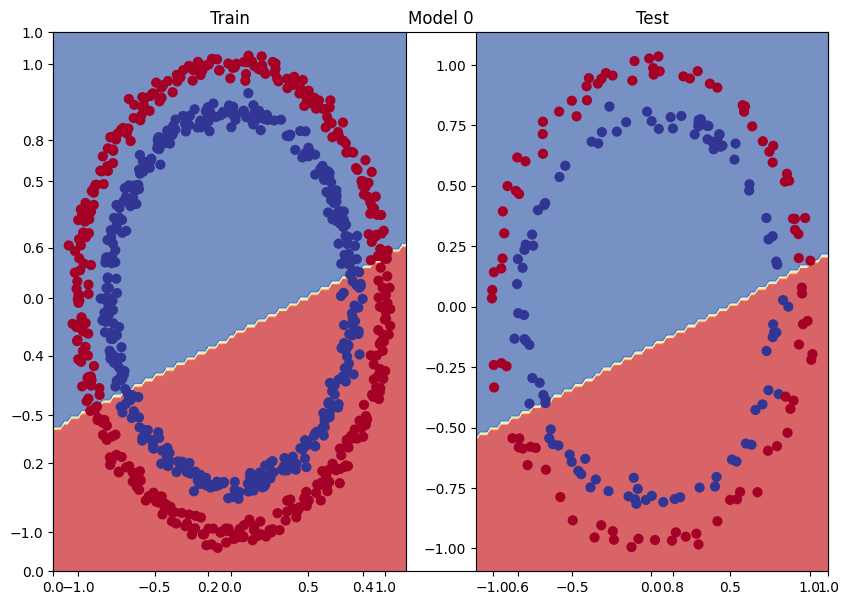

In [105]:
plt.figure(figsize=(10, 7))
plt.title("Model 0")
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X=X_train, y=y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X=X_test, y=y_test)

plt.show()

### 5. Improving model

In [31]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 64)
        self.layer_2 = nn.Linear(64, 100)
        self.layer_3 = nn.Linear(100, 128)
        self.layer_4 = nn.Linear(128, 10)
        self.layer_5 = nn.Linear(10, 1)

    def forward(self, x):
        x = self.layer_1(x)
        x = self.layer_2(x)
        x = self.layer_3(x)
        x = self.layer_4(x)
        x = self.layer_5(x)
        return x
    
model_1 = CircleModelV1().to(device)
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=10, bias=True)
  (layer_5): Linear(in_features=10, out_features=1, bias=True)
)

In [32]:
# Create a loss
loss_fn = nn.BCEWithLogitsLoss()

# Create an optimizer
optimizer = torch.optim.SGD(model_1.parameters(), lr=0.001)

In [33]:
## Training loop

Epochs = 1000
torch.manual_seed(42)
torch.cuda.manual_seed(42)

for epoch in range(Epochs):
    # Training mode
    model_1.train()

    # Forward pass
    y_logits = model_1(X_train).squeeze()
    y_labels = torch.round(torch.sigmoid(y_logits))

    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_labels)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the model
    optimizer.step()

    # Test the model
    model_1.eval()
    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    # Print some metrics
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")


Epoch: 0 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 50 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 100 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 150 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 200 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 250 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 300 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 350 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 400 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 450 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 500 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.70 | Test Accuracy: 50.00
Epoch: 550 | Loss: 0.70 | Accuracy: 50.00 | Test Loss: 0.69 | Test Accuracy: 50.00
Epoch: 

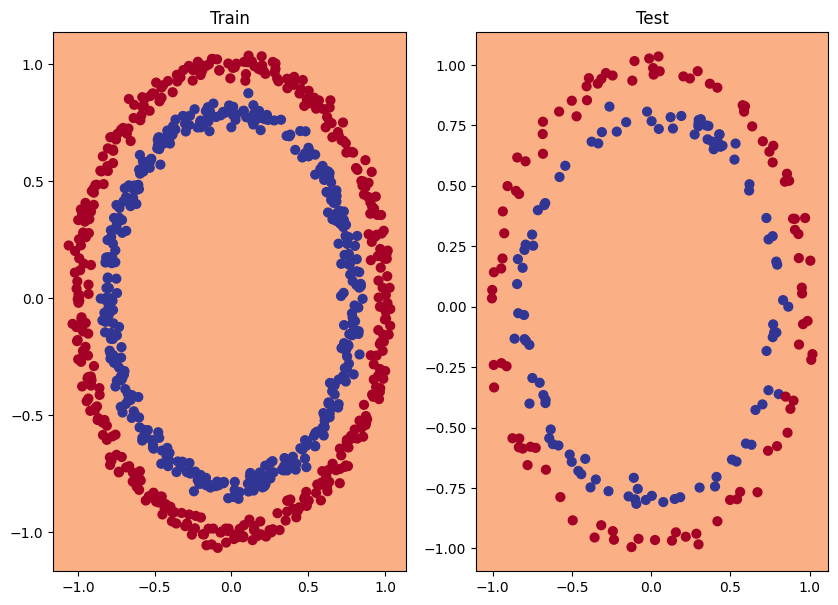

In [34]:
plt.figure(figsize=(10, 7))

plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X=X_train, y=y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X=X_test, y=y_test)

plt.show()

#### Preparing data to see if our model can fit a straight line

In [37]:
# Create some data
weight = 0.7
bias = 0.3
start = 0
end = 1
step = 0.01

# Create data
X_regression = torch.arange(start, end, step).unsqueeze(dim=1)
y_regression = weight * X_regression + bias

# Check the data
print(len(X_regression), len(y_regression))
print(X_regression[:10], y_regression[:10])

100 100
tensor([[0.0000],
        [0.0100],
        [0.0200],
        [0.0300],
        [0.0400],
        [0.0500],
        [0.0600],
        [0.0700],
        [0.0800],
        [0.0900]]) tensor([[0.3000],
        [0.3070],
        [0.3140],
        [0.3210],
        [0.3280],
        [0.3350],
        [0.3420],
        [0.3490],
        [0.3560],
        [0.3630]])


In [38]:
# Create train and test splits
train_split = int(0.8 * len(X_regression))
X_train_regression, X_test_regression = X_regression[:train_split], X_regression[train_split:]
y_train_regression, y_test_regression = y_regression[:train_split], y_regression[train_split:]

# Check the lengths
len(X_train_regression), len(X_test_regression), len(y_train_regression), len(y_test_regression)

(80, 20, 80, 20)

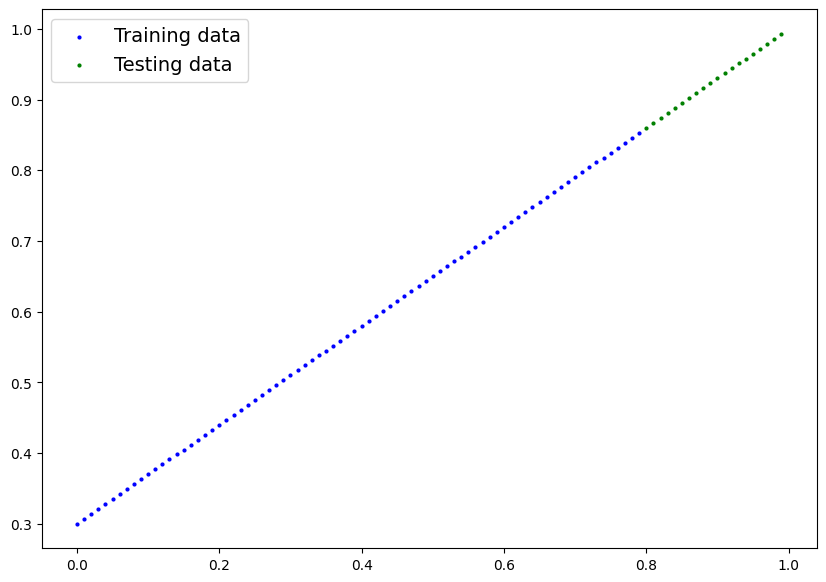

In [39]:
from utils import plot_predictions
plot_predictions(X_train_regression,
                 y_train_regression, 
                 X_test_regression, 
                 y_test_regression)

In [40]:
model_1

CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=64, bias=True)
  (layer_2): Linear(in_features=64, out_features=100, bias=True)
  (layer_3): Linear(in_features=100, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=10, bias=True)
  (layer_5): Linear(in_features=10, out_features=1, bias=True)
)

In [42]:
### 5.2 Adjusting `model_1` to fit a straight line

model_2 = nn.Sequential(
    nn.Linear(1, 10),
    nn.Linear(10, 64),
    nn.Linear(64, 100),
    nn.Linear(100, 64),
    nn.Linear(64, 10),
    nn.Linear(10, 1)
)

model_2

Sequential(
  (0): Linear(in_features=1, out_features=10, bias=True)
  (1): Linear(in_features=10, out_features=64, bias=True)
  (2): Linear(in_features=64, out_features=100, bias=True)
  (3): Linear(in_features=100, out_features=64, bias=True)
  (4): Linear(in_features=64, out_features=10, bias=True)
  (5): Linear(in_features=10, out_features=1, bias=True)
)

In [43]:
# Loss and optimizer
loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model_2.parameters(), lr=0.001)


In [45]:
# Train the model
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Epochs = 1000

# Put data on the GPU
X_train_regression, y_train_regression = X_train_regression.to(device), y_train_regression.to(device)
X_test_regression, y_test_regression = X_test_regression.to(device), y_test_regression.to(device)

for epoch in range(Epochs):
    # training mode
    model_2.train()

    # Forward pass
    y_preds = model_2(X_train_regression)

    # Calculate loss
    loss = loss_fn(y_preds, y_train_regression)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the model
    optimizer.step()

    # Test the model
    model_2.eval()
    with torch.inference_mode():
        test_preds = model_2(X_test_regression)
        test_loss = loss_fn(test_preds, y_test_regression)

    # Print some metrics
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f} | Test Loss: {test_loss:.5f}")

Epoch: 0 | Loss: 0.05450 | Test Loss: 0.12472
Epoch: 50 | Loss: 0.05029 | Test Loss: 0.11346
Epoch: 100 | Loss: 0.04590 | Test Loss: 0.10289
Epoch: 150 | Loss: 0.04131 | Test Loss: 0.09258
Epoch: 200 | Loss: 0.03650 | Test Loss: 0.08175
Epoch: 250 | Loss: 0.03146 | Test Loss: 0.07046
Epoch: 300 | Loss: 0.02615 | Test Loss: 0.05845
Epoch: 350 | Loss: 0.02056 | Test Loss: 0.04584
Epoch: 400 | Loss: 0.01465 | Test Loss: 0.03257
Epoch: 450 | Loss: 0.00839 | Test Loss: 0.01835
Epoch: 500 | Loss: 0.00175 | Test Loss: 0.00352
Epoch: 550 | Loss: 0.00169 | Test Loss: 0.00878
Epoch: 600 | Loss: 0.00162 | Test Loss: 0.00892
Epoch: 650 | Loss: 0.00155 | Test Loss: 0.00878
Epoch: 700 | Loss: 0.00169 | Test Loss: 0.00893
Epoch: 750 | Loss: 0.00163 | Test Loss: 0.00878
Epoch: 800 | Loss: 0.00176 | Test Loss: 0.00893
Epoch: 850 | Loss: 0.00170 | Test Loss: 0.00878
Epoch: 900 | Loss: 0.00184 | Test Loss: 0.00893
Epoch: 950 | Loss: 0.00177 | Test Loss: 0.00878


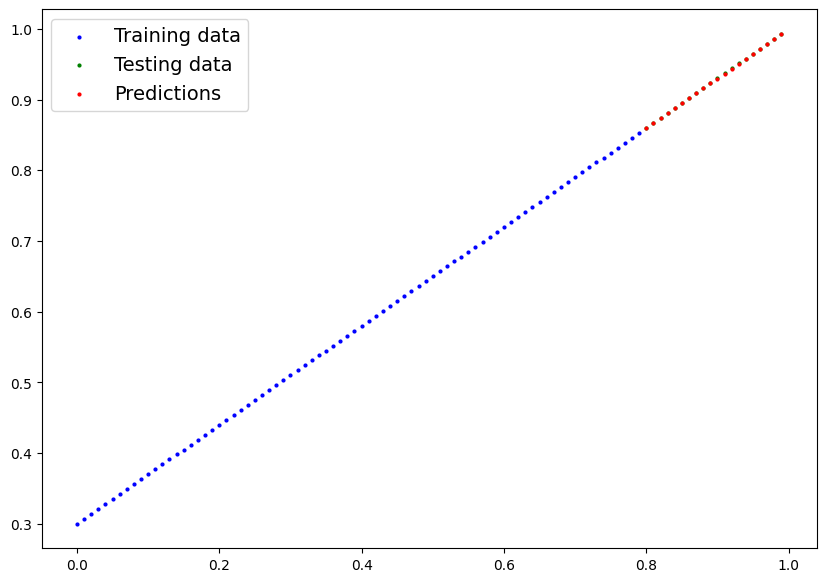

In [47]:
# Turn on evaluation mode
model_2.eval()

# Make predictions
with torch.inference_mode():
    y_preds = model_2(X_test_regression)

# Plot the predictions
plot_predictions(X_train_regression, y_train_regression, X_test_regression, y_test_regression, y_preds)

plt.show()

##### 6. The missing piece: non-linearity

In [48]:
X_train

tensor([[ 0.6579, -0.4651],
        [ 0.6319, -0.7347],
        [-1.0086, -0.1240],
        ...,
        [ 0.0157, -1.0300],
        [ 1.0110,  0.1680],
        [ 0.5578, -0.5709]])

#### Building a model with non-linearity


In [129]:
from torch import nn
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 4)
        self.layer_2 = nn.Linear(4, 8)
        self.layer_3 = nn.Linear(8, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.layer_3(x)
        return x


class CircleModelV3(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(2, 8)
        self.layer_2 = nn.Linear(8, 16)
        self.layer_3 = nn.Linear(16, 64)
        self.layer_4 = nn.Linear(64, 128)
        self.layer_5 = nn.Linear(128, 64)
        self.layer_6 = nn.Linear(64, 32)
        self.layer_7 = nn.Linear(32, 10)
        self.layer_8 = nn.Linear(10, 1)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.relu(self.layer_4(x))
        x = self.relu(self.layer_5(x))
        x = self.relu(self.layer_6(x))
        x = self.relu(self.layer_7(x))
        x = self.layer_8(x)
        return x



model_3 = CircleModelV2().to(device)
model_3

model_4 = CircleModelV3().to(device)
model_4

CircleModelV3(
  (layer_1): Linear(in_features=2, out_features=8, bias=True)
  (layer_2): Linear(in_features=8, out_features=16, bias=True)
  (layer_3): Linear(in_features=16, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=128, bias=True)
  (layer_5): Linear(in_features=128, out_features=64, bias=True)
  (layer_6): Linear(in_features=64, out_features=32, bias=True)
  (layer_7): Linear(in_features=32, out_features=10, bias=True)
  (layer_8): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [132]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001, weight_decay=0.0001)

In [134]:
# Random seeds
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Training loop
Epochs = 1500

for epoch in range(Epochs):
    #training mode
    model_4.train()

    # Forward pass
    y_logits = model_4(X_train).squeeze()
    y_labels = torch.round(torch.sigmoid(y_logits))

    # Calculate loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_train, y_labels)

    # Zero the gradients
    optimizer.zero_grad()

    # backward pass
    loss.backward()

    # Update the model
    optimizer.step()

    # Test the model
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(y_test, test_preds)

    # Print some metrics
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.2f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.2f} | Test Accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 50 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 100 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 150 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 200 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 250 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 300 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 350 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.00 | Test Accuracy: 100.00
Epoch: 400 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 450 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.00 | Test Accuracy: 100.00
Epoch: 500 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.01 | Test Accuracy: 100.00
Epoch: 550 | Loss: 0.00 | Accuracy: 100.00 | Test Loss: 0.00 | Test 

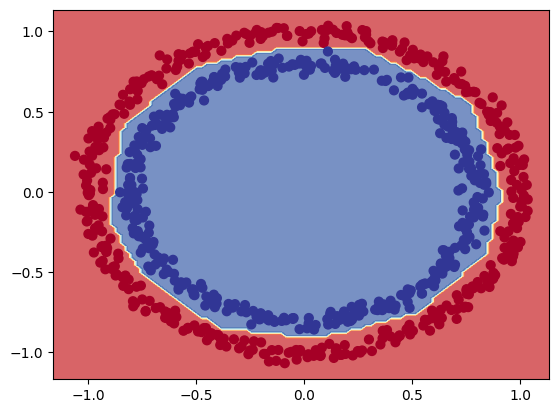

In [135]:
plot_decision_boundary(model_4, X=X_train, y=y_train)

#### 6.4 Evaluating a model trained with non-linear activation functions


In [136]:
# Makes predictions
model_4.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_4(X_test).squeeze()))
y_preds

tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
        1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 1., 0., 1.,
        1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 0., 0., 0., 0.,
        1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 1., 0.,
        0., 1., 1., 1., 1., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0., 0., 1., 0.,
        0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 1., 0.,
        1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 1.,
        0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 0., 1.,
        1., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1., 0.,
        0., 1., 0., 1., 1., 0., 0., 0., 1., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
        1., 1.])

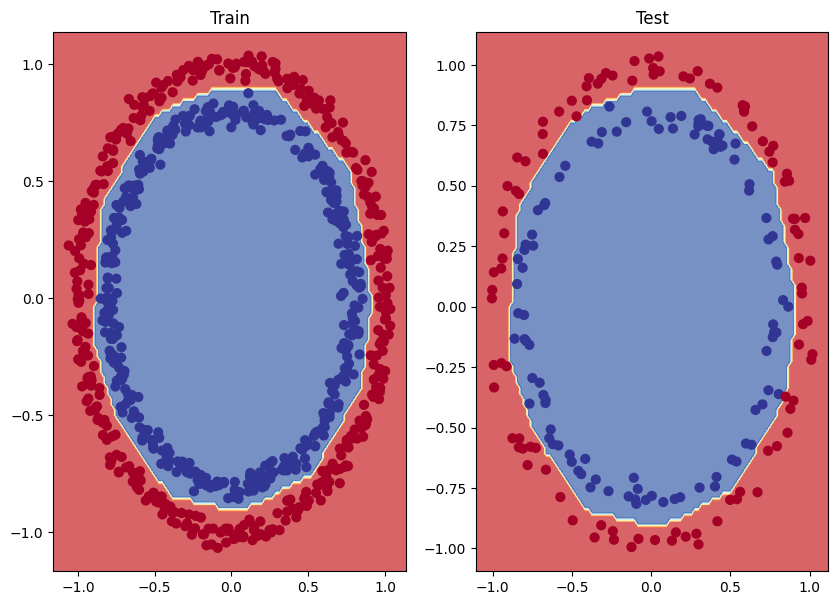

In [137]:
# plot devision boudaries
plt.figure(figsize=(10, 7))

plt.subplot(1,2,1)
plt.title("Train")
plot_decision_boundary(model_4, X=X_train, y=y_train)

plt.subplot(1,2,2)
plt.title("Test")
plot_decision_boundary(model_4, X=X_test, y=y_test)

plt.show()

#### 7. Replicating non-linear activation functions

Neural network, ranther than us telling the model what to learn, we let the model learn the patterns in the data.



In [141]:
# Create a tensor
A = torch.arange(-10, 10, 1, dtype = torch.float)
A

tensor([-10.,  -9.,  -8.,  -7.,  -6.,  -5.,  -4.,  -3.,  -2.,  -1.,   0.,   1.,
          2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.])

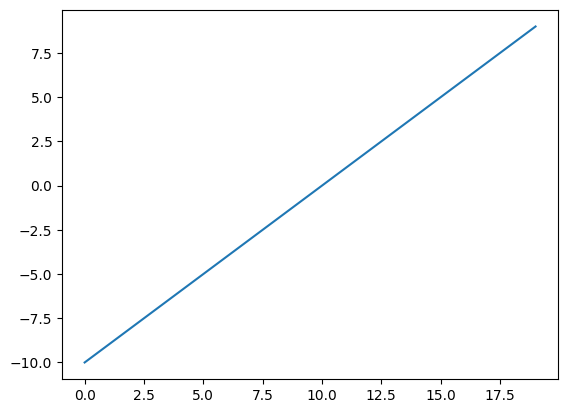

In [142]:
plt.plot(A);

In [146]:
# Replicating ReLU
def relu(x):
    return torch.maximum(torch.tensor(0), x)

In [148]:
relu(A)

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 2., 3., 4., 5., 6., 7.,
        8., 9.])

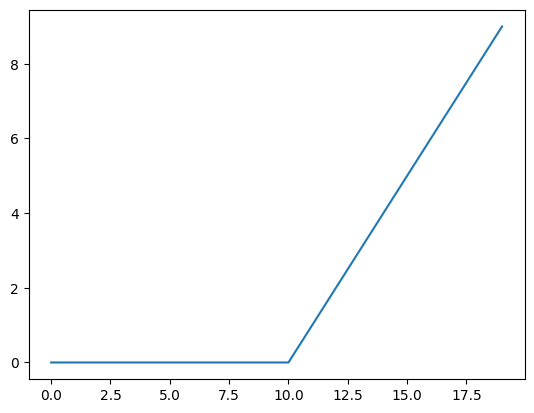

In [150]:
plt.plot(relu(A));

In [151]:
# Replicating Sigmoid

def sigmoid(x):
    return 1 / (1 + torch.exp(-x))

In [152]:
sigmoid(A)

tensor([4.5398e-05, 1.2339e-04, 3.3535e-04, 9.1105e-04, 2.4726e-03, 6.6929e-03,
        1.7986e-02, 4.7426e-02, 1.1920e-01, 2.6894e-01, 5.0000e-01, 7.3106e-01,
        8.8080e-01, 9.5257e-01, 9.8201e-01, 9.9331e-01, 9.9753e-01, 9.9909e-01,
        9.9966e-01, 9.9988e-01])

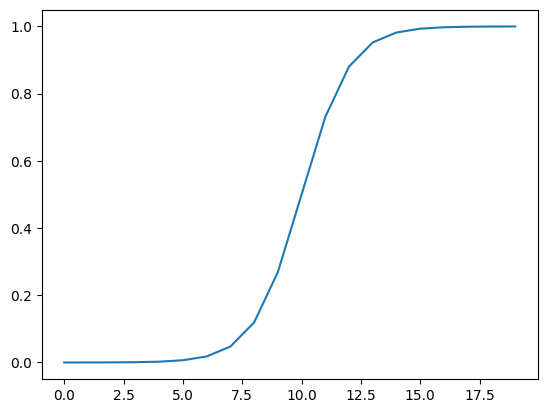

In [153]:
plt.plot(sigmoid(A));

### 8. Putting together eeverything we've learned for a multi-class classification problem


#### 8.1 Creating a toy multi-class dataset

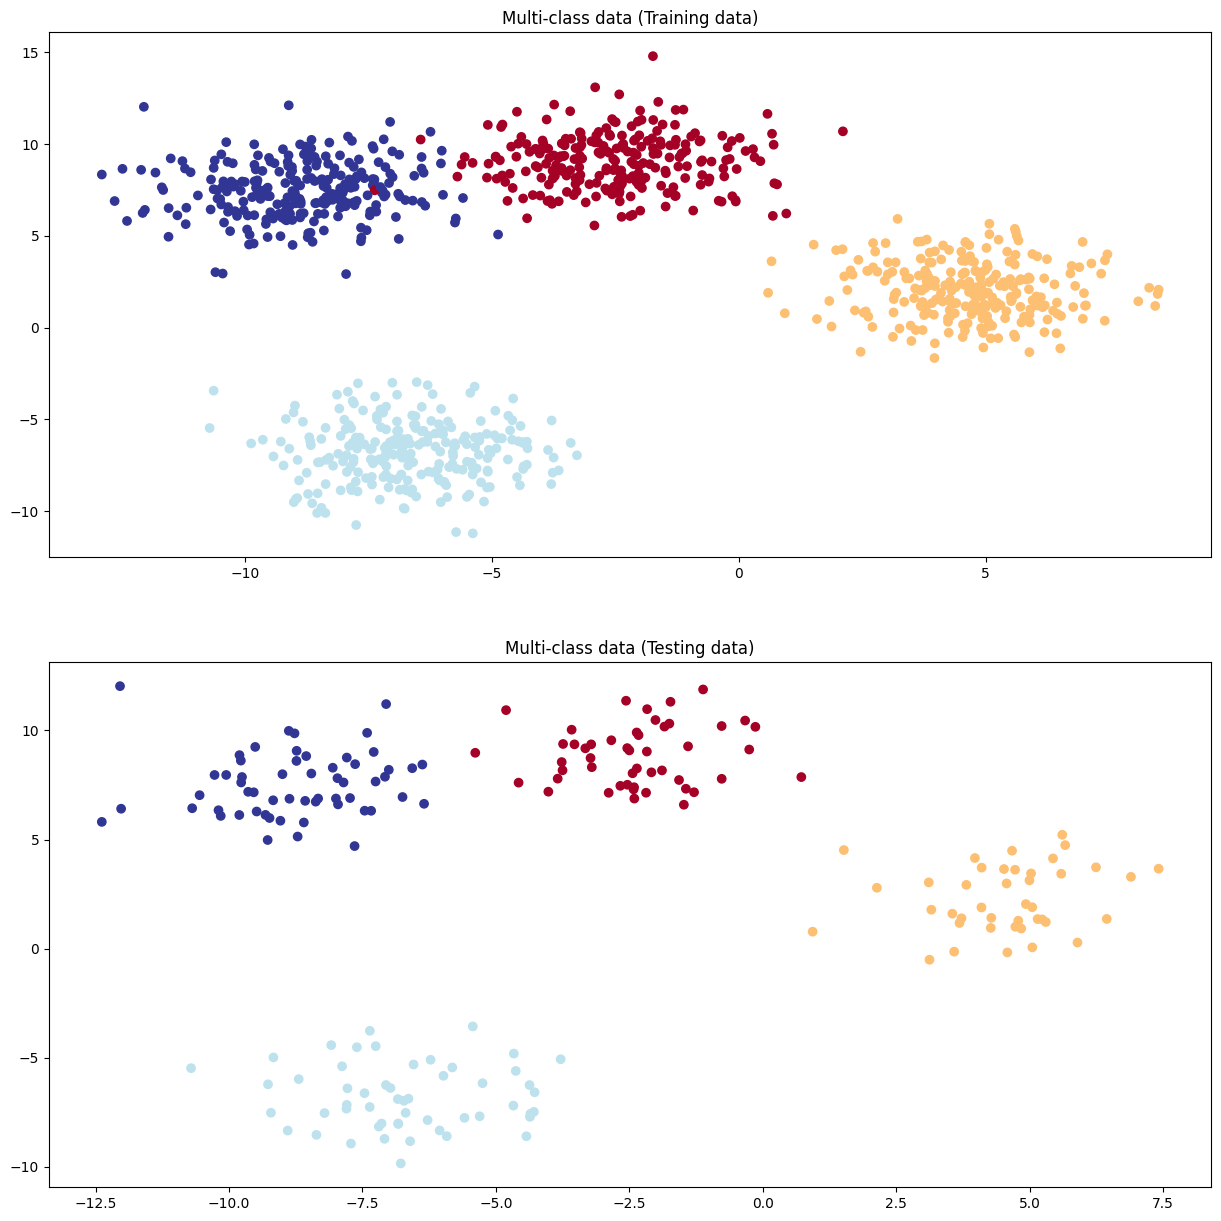

In [189]:
# Import dependencies

import torch
import matplotlib.pyplot as plt
import matplotlib
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hypeerparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_STATE = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(
    n_samples=1000,
    centers=NUM_CLASSES,
    n_features=NUM_FEATURES,
    cluster_std = 1.5, 
    random_state=RANDOM_STATE
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float32)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)

# 3. Split the data
X_train_blob, X_test_blob, y_train_blob, y_test_blob = train_test_split(
    X_blob, y_blob, test_size=0.2, random_state=RANDOM_STATE
)

# 4. Plot data
plt.figure(figsize=(15, 15))
plt.subplot(2, 1, 1)
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu)
plt.title("Multi-class data (Training data)")

plt.subplot(2, 1, 2)
plt.scatter(X_test_blob[:, 0], X_test_blob[:, 1], c=y_test_blob, cmap=plt.cm.RdYlBu)
plt.title("Multi-class data (Testing data)")
plt.show()

#### 8.2 Building a multi-class classification model in PyTorch 

In [190]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [206]:
# Create a model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """ Initializes multi-class classification model
        Args:
            input_features: number of input features
            output_features: number of output features
            hidden_units: number of hidden units

        Returns:
            None
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
        nn.Linear(input_features, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, hidden_units**2),
        nn.ReLU(),
        nn.Linear(hidden_units**2, hidden_units),
        nn.ReLU(),
        nn.Linear(hidden_units, output_features),
        )
    
    def forward(self, x):
        return self.linear_layer_stack(x)

# Create ana instance of BlobModel and send it to the target device
model_4 = BlobModel(
    input_features=NUM_FEATURES,
    output_features=NUM_CLASSES
).to(device)
    
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=8, bias=True)
    (5): ReLU()
    (6): Linear(in_features=8, out_features=4, bias=True)
  )
)

In [207]:
X_train_blob.shape, y_train_blob.shape

(torch.Size([800, 2]), torch.Size([800]))

In [208]:
X_train_blob[:5], y_train_blob[:5]

(tensor([[ 5.0405,  3.3076],
         [-2.6249,  9.5260],
         [-8.5240, -9.0402],
         [-6.0262, -4.4375],
         [-3.3397,  7.2175]]),
 tensor([1, 0, 2, 2, 0]))

In [209]:
torch.unique(y_train_blob)

tensor([0, 1, 2, 3])

#### 8.3 Create a loss function and optimizer for the BlobModel

In [210]:
# Create a loss function for multiclass classification
loss_fn = nn.CrossEntropyLoss()

# Create an optimizer
optimizer = torch.optim.Adam(model_4.parameters(), lr=0.001)

#### 8.4 Getting prediction probabilities for a multi-class PyTorch model

In order to evaluate and train and test out model, we need to convert the output of our model into probabilities. 
We can do this by using the softmax activation function.


In [211]:
model_4.eval()
with torch.inference_mode():
    y_preds = model_4(X_test_blob)

y_preds[:5]

tensor([[ 0.4967, -0.4153, -0.3862, -0.1183],
        [ 0.4851, -0.4094, -0.4235, -0.0929],
        [ 0.8020, -0.4948, -0.0455, -0.1188],
        [ 0.4273, -0.3812, -0.3235, -0.0884],
        [ 0.6197, -0.3696, -0.4694, -0.1653]])

In [212]:
# Convert our model's logit outputs to prediction probabilites
y_pred_probs = nn.functional.softmax(y_preds, dim=1)
y_pred_probs[:5]

tensor([[0.4244, 0.1705, 0.1756, 0.2295],
        [0.4214, 0.1723, 0.1699, 0.2364],
        [0.4762, 0.1302, 0.2040, 0.1896],
        [0.3977, 0.1772, 0.1877, 0.2374],
        [0.4620, 0.1718, 0.1555, 0.2107]])

In [213]:
torch.sum(y_pred_probs[0])

tensor(1.0000)

In [214]:
torch.max(y_pred_probs[0])

tensor(0.4244)

In [215]:
torch.argmax(y_pred_probs, dim=1)

tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])

#### 8.5 Creating a training loop and testing loop for a multi-class PyTorch Model

In [218]:
# practice
torch.manual_seed(42)
torch.cuda.manual_seed(42)

Epochs = 1000

# Put data on the GPU
X_train_blob, y_train_blob = X_train_blob.to(device), y_train_blob.to(device)
X_test_blob, y_test_blob = X_test_blob.to(device), y_test_blob.to(device)

# Training loop
for epoch in range(Epochs):
    # Training Mode
    model_4.train()

    # Forward pass
    y_logits = model_4(X_train_blob)
    y_preds = nn.functional.softmax(y_logits, dim=1).argmax(dim=1)

    # Calculate loss
    loss = loss_fn(y_logits, y_train_blob.type(torch.LongTensor))
    acc = accuracy_fn(y_train_blob, y_preds)

    # Zero the gradients
    optimizer.zero_grad()

    # Backward pass
    loss.backward()

    # Update the model
    optimizer.step()

    # Testing loop
    model_4.eval()
    with torch.inference_mode():
        test_logits = model_4(X_test_blob)
        test_preds = nn.functional.softmax(test_logits, dim=1).argmax(dim=1)

        test_loss = loss_fn(test_logits, y_test_blob)
        test_acc = accuracy_fn(y_test_blob, test_preds)

    # Output some metrics
    if epoch % 50 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.4f} | Accuracy: {acc:.2f} | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}")

Epoch: 0 | Loss: 0.0163 | Accuracy: 99.50 | Test Loss: 0.0057 | Test Accuracy: 100.00
Epoch: 50 | Loss: 0.0161 | Accuracy: 99.50 | Test Loss: 0.0054 | Test Accuracy: 100.00
Epoch: 100 | Loss: 0.0159 | Accuracy: 99.50 | Test Loss: 0.0052 | Test Accuracy: 100.00
Epoch: 150 | Loss: 0.0156 | Accuracy: 99.50 | Test Loss: 0.0050 | Test Accuracy: 100.00
Epoch: 200 | Loss: 0.0154 | Accuracy: 99.50 | Test Loss: 0.0047 | Test Accuracy: 100.00
Epoch: 250 | Loss: 0.0153 | Accuracy: 99.38 | Test Loss: 0.0045 | Test Accuracy: 100.00
Epoch: 300 | Loss: 0.0151 | Accuracy: 99.38 | Test Loss: 0.0043 | Test Accuracy: 100.00
Epoch: 350 | Loss: 0.0149 | Accuracy: 99.38 | Test Loss: 0.0041 | Test Accuracy: 100.00
Epoch: 400 | Loss: 0.0148 | Accuracy: 99.38 | Test Loss: 0.0040 | Test Accuracy: 100.00
Epoch: 450 | Loss: 0.0146 | Accuracy: 99.38 | Test Loss: 0.0038 | Test Accuracy: 100.00
Epoch: 500 | Loss: 0.0145 | Accuracy: 99.38 | Test Loss: 0.0037 | Test Accuracy: 100.00
Epoch: 550 | Loss: 0.0144 | Accurac

#### 8.6 Making and evaluating predictions with PyTorch Model

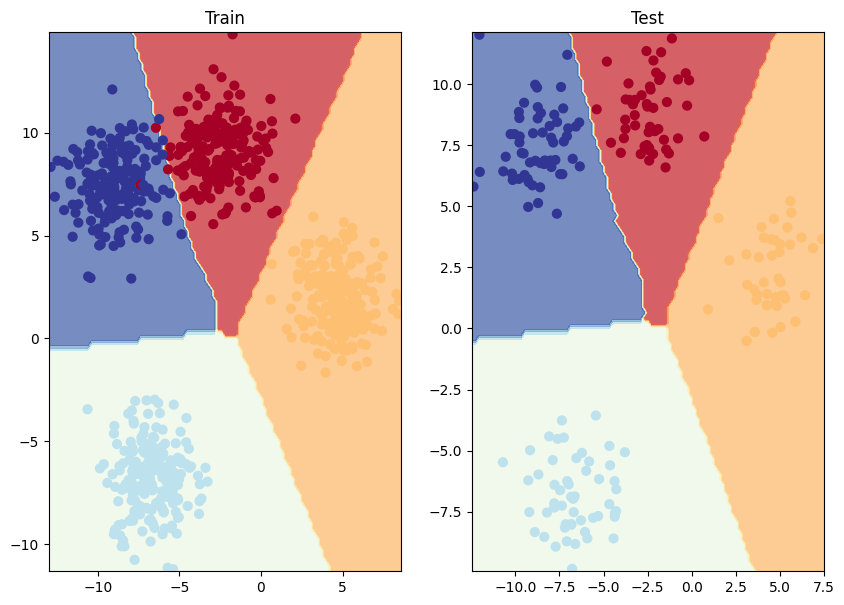

In [219]:
#### Vizualize the plot decision boundaries

plt.figure(figsize=(10, 7))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X=X_train_blob, y=y_train_blob)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X=X_test_blob, y=y_test_blob)

plt.show()

##### 9. A few more classification metrics... (to evaluate our model)

* Accuracy - out of 100 examples, how many did the model get correct?
* Precision - out of the positive predictions the model made, how many were correct?
* Recall - out of the actual positives, how many did the model correctly predict?
* F1 score - the harmonic mean of precision and recall. A combination of precision and recall.
* Confusion matrix - a table comparing the actual values to the predicted values.
* Classification report - a collection of the main classification metrics (precision, recall, f1-score, accuracy) in one place.